In [42]:
# Loading in all of my necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
pd.set_option('display.max_columns', None)

# Reading in  Data

## Taxi zones lookup table

In [43]:
# Reading in the Taxi Zones Lookup table and taking a look at it
Taxi_Zones = pd.read_csv("taxi_zone_lookup.csv")
Taxi_Zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


## Yellow taxi dataset

In [44]:
# Reading in my Yellow Taxi Cab dataset and inspecting its shape
Taxi_Data = pd.read_parquet("yellow_tripdata_2020-01.parquet")
print(Taxi_Data.shape)

(6405008, 19)


# Data cleaning

## Using Location ID to find borough and zone

In [45]:
# Build lookup dictionaries
borough_lookup = Taxi_Zones.set_index("LocationID")["Borough"].to_dict()
zone_lookup    = Taxi_Zones.set_index("LocationID")["Zone"].to_dict()

# Map directly into Taxi_Data
Taxi_Data["PU_Borough"] = Taxi_Data["PULocationID"].map(borough_lookup)
Taxi_Data["PU_Zone"]    = Taxi_Data["PULocationID"].map(zone_lookup)
Taxi_Data["DO_Borough"] = Taxi_Data["DOLocationID"].map(borough_lookup)
Taxi_Data["DO_Zone"]    = Taxi_Data["DOLocationID"].map(zone_lookup)

# Optional: reorder so new cols sit after IDs
cols = list(Taxi_Data.columns)
for loc, boro, zone in [
    ("PULocationID", "PU_Borough", "PU_Zone"),
    ("DOLocationID", "DO_Borough", "DO_Zone")
]:
    idx = cols.index(loc)
    cols = cols[:idx+1] + [boro, zone] + [c for c in cols[idx+1:] if c not in [boro, zone]]

Taxi_Data = Taxi_Data[cols]

## Inspecting columns and rows

In [46]:
# Taking a Look at the dataset to see if my columpns updated correctly
Taxi_Data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,PU_Borough,PU_Zone,DOLocationID,DO_Borough,DO_Zone,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,Manhattan,Upper West Side North,239,Manhattan,Upper West Side South,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,Manhattan,Upper West Side South,238,Manhattan,Upper West Side North,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,Manhattan,Upper West Side North,238,Manhattan,Upper West Side North,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,Manhattan,Upper West Side North,151,Manhattan,Manhattan Valley,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,Queens,Queensbridge/Ravenswood,193,Queens,Queensbridge/Ravenswood,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


### Converting Pickup and Drop off Columns to datetime format

In [47]:
# Converting pickuo and drop off columns to datetime objects
Taxi_Data['tpep_pickup_datetime'] = pd.to_datetime(Taxi_Data['tpep_pickup_datetime'])
Taxi_Data['tpep_dropoff_datetime'] = pd.to_datetime(Taxi_Data['tpep_dropoff_datetime'])

### Engineering new date features

In [48]:
Taxi_Data['trip_duration'] = ( (Taxi_Data['tpep_dropoff_datetime'] - Taxi_Data['tpep_pickup_datetime']).dt.total_seconds() / 60).round(2)
Taxi_Data['pickup_date'] = Taxi_Data['tpep_pickup_datetime'].dt.date
Taxi_Data['pickup_hour'] = Taxi_Data['tpep_pickup_datetime'].dt.hour
Taxi_Data['pickup_dayofweek'] = Taxi_Data['tpep_pickup_datetime'].dt.dayofweek
Taxi_Data['pickup_minute'] = Taxi_Data['tpep_pickup_datetime'].dt.minute
Taxi_Data['dropoff_minute'] = Taxi_Data['tpep_dropoff_datetime'].dt.minute
# Dropoff features
Taxi_Data['dropoff_date'] = Taxi_Data['tpep_dropoff_datetime'].dt.date
Taxi_Data['dropoff_hour'] = Taxi_Data['tpep_dropoff_datetime'].dt.hour
Taxi_Data['dropoff_dayofweek'] = Taxi_Data['tpep_dropoff_datetime'].dt.dayofweek

### Resetting the order of columns

In [49]:
# Define the exact column order you want
new_order = [
    'VendorID',
    'tpep_pickup_datetime',
    'pickup_date', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek', 'PULocationID',
    'PU_Borough', 'PU_Zone',
    'tpep_dropoff_datetime',
    'dropoff_date', 'dropoff_hour', 'dropoff_minute', 'dropoff_dayofweek','DOLocationID',
    'DO_Borough', 'DO_Zone',
    'trip_distance', 'trip_duration',
    'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
    'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge'
]

# Reorder the DataFrame
Taxi_Data = Taxi_Data[new_order]
Taxi_Data['pickup_date'] = pd.to_datetime(Taxi_Data['pickup_date'])
Taxi_Data['dropoff_date'] = pd.to_datetime(Taxi_Data['dropoff_date'])


In [50]:
Taxi_Data

,VendorID,tpep_pickup_datetime,pickup_date,pickup_hour,pickup_minute,pickup_dayofweek,PULocationID,PU_Borough,PU_Zone,tpep_dropoff_datetime,dropoff_date,dropoff_hour,dropoff_minute,dropoff_dayofweek,DOLocationID,DO_Borough,DO_Zone,trip_distance,trip_duration,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-01-01 00:28:15,2020-01-01,0,28,2,238,Manhattan,Upper West Side North,2020-01-01 00:33:03,2020-01-01,0,33,2,239,Manhattan,Upper West Side South,1.20,4.80,1.0,1.0,N,1,6.00,3.00,0.5,1.47,0.00,0.3,11.27,2.5
1,1,2020-01-01 00:35:39,2020-01-01,0,35,2,239,Manhattan,Upper West Side South,2020-01-01 00:43:04,2020-01-01,0,43,2,238,Manhattan,Upper West Side North,1.20,7.42,1.0,1.0,N,1,7.00,3.00,0.5,1.50,0.00,0.3,12.30,2.5
2,1,2020-01-01 00:47:41,2020-01-01,0,47,2,238,Manhattan,Upper West Side North,2020-01-01 00:53:52,2020-01-01,0,53,2,238,Manhattan,Upper West Side North,0.60,6.18,1.0,1.0,N,1,6.00,3.00,0.5,1.00,0.00,0.3,10.80,2.5
3,1,2020-01-01 00:55:23,2020-01-01,0,55,2,238,Manhattan,Upper West Side North,2020-01-01 01:00:14,2020-01-01,1,0,2,151,Manhattan,Manhattan Valley,0.80,4.85,1.0,1.0,N,1,5.50,0.50,0.5,1.36,0.00,0.3,8.16,0.0
4,2,2020-01-01 00:01:58,2020-01-01,0,1,2,193,Queens,Queensbridge/Ravenswood,2020-01-01 00:04:16,2020-01-01,0,4,2,193,Queens,Queensbridge/Ravenswood,0.00,2.30,1.0,1.0,N,2,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,2,2020-01-31 23:08:00,2020-01-31,23,8,4,191,Queens,Queens Village,2020-01-31 23:34:00,2020-01-31,23,34,4,35,Brooklyn,Brownsville,12.07,26.00,NaN,NaN,None,0,52.18,2.75,0.5,0.00,0.00,0.3,55.73,NaN
6405004,2,2020-01-31 23:00:00,2020-01-31,23,0,4,186,Manhattan,Penn Station/Madison Sq West,2020-01-31 23:44:00,2020-01-31,23,44,4,117,Queens,Hammels/Arverne,23.48,44.00,NaN,NaN,None,0,54.01,2.75,0.5,0.00,6.12,0.3,63.68,NaN
6405005,2,2020-01-31 23:13:00,2020-01-31,23,13,4,164,Manhattan,Midtown South,2020-01-31 23:38:00,2020-01-31,23,38,4,131,Queens,Jamaica Estates,12.09,25.00,NaN,NaN,None,0,38.02,2.75,0.5,0.00,6.12,0.3,47.69,NaN
6405006,2,2020-01-31 23:02:54,2020-01-31,23,2,4,10,Queens,Baisley Park,2020-01-31 23:27:10,2020-01-31,23,27,4,16,Queens,Bayside,11.65,24.27,NaN,NaN,None,0,28.74,2.75,0.0,0.00,0.00,0.3,31.79,NaN


## Inspecting null values

In [51]:
# Count of the null values seen in each column of the dataset
Taxi_Data.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
pickup_date                  0
pickup_hour                  0
pickup_minute                0
pickup_dayofweek             0
PULocationID                 0
PU_Borough                3160
PU_Zone                  43958
tpep_dropoff_datetime        0
dropoff_date                 0
dropoff_hour                 0
dropoff_minute               0
dropoff_dayofweek            0
DOLocationID                 0
DO_Borough               15100
DO_Zone                  39782
trip_distance                0
trip_duration                0
passenger_count          65441
RatecodeID               65441
store_and_fwd_flag       65441
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     65441
dtype: int64

In [52]:
# Count rows with Y vs N in store_and_fwd_flag
print(Taxi_Data['store_and_fwd_flag'].value_counts(dropna=False))

store_and_fwd_flag
N       6271447
Y         68120
None      65441
Name: count, dtype: int64


###  NAN's  from 'store_and_fwd_flag' 

In [53]:
# Creating a df of all the rows with missing values in its "store_and_fwd_column"
missing_fwd = Taxi_Data[Taxi_Data['store_and_fwd_flag'].isna()]

# Count how many of these also have passenger_count or RatecodeID missing
print("Total rows with store_and_fwd_flag NaN:", missing_fwd.shape[0])
print("... with passenger_count NaN:", missing_fwd['passenger_count'].isna().sum())
print("... with RatecodeID NaN:", missing_fwd['RatecodeID'].isna().sum())

# Rows where all 3 are missing
all_three_missing = missing_fwd[
    missing_fwd['passenger_count'].isna() & missing_fwd['RatecodeID'].isna()
]
print("Rows with all three missing:", all_three_missing.shape[0])

print("Rows dropped:", Taxi_Data['store_and_fwd_flag'].isna().sum())

# Drop rows where passenger_count, RatecodeID, and store_and_fwd_flag are all NaN
Taxi_Data = Taxi_Data.dropna(subset=['passenger_count', 'RatecodeID', 'store_and_fwd_flag'])

Total rows with store_and_fwd_flag NaN: 65441
... with passenger_count NaN: 65441
... with RatecodeID NaN: 65441
Rows with all three missing: 65441
Rows dropped: 65441


### NA's from Location ID

In [54]:
# Location ID's 264 and 265 are special ID's
# 264's Borough is "unknown" and its zone is "NaN"
# 265's borough is NaN and its zone is "Outside of NYC"
special_ids = [264, 265]

summary = []

# Tabling the amount of rows with 264 o4 265 as its DO or PU ID 
# Checking if Nan's in Borough or Zone are due to its location ID being 264 or 265
for loc_id in special_ids:
    # PU stats
    pu_rows = Taxi_Data[Taxi_Data['PULocationID'] == loc_id]
    pu_total = len(pu_rows)
    pu_missing_borough = pu_rows['PU_Borough'].isna().sum()
    pu_missing_zone = pu_rows['PU_Zone'].isna().sum()
    
    # DO stats
    do_rows = Taxi_Data[Taxi_Data['DOLocationID'] == loc_id]
    do_total = len(do_rows)
    do_missing_borough = do_rows['DO_Borough'].isna().sum()
    do_missing_zone = do_rows['DO_Zone'].isna().sum()
    
    summary.append({
        "LocationID": loc_id,
        "PU_Count": pu_total,
        "PU_Borough_NaN": pu_missing_borough,
        "PU_Zone_NaN": pu_missing_zone,
        "DO_Count": do_total,
        "DO_Borough_NaN": do_missing_borough,
        "DO_Zone_NaN": do_missing_zone
    })

summary_df = pd.DataFrame(summary)
summary_df


,LocationID,PU_Count,PU_Borough_NaN,PU_Zone_NaN,DO_Count,DO_Borough_NaN,DO_Zone_NaN
0,264,43779,0,43779,39678,0,39678
1,265,3090,3090,0,14858,14858,0


In [55]:
# Counting the amount of rows with Location ID of 264
count_264 = Taxi_Data[
    (Taxi_Data['PULocationID'] == 264) | (Taxi_Data['DOLocationID'] == 264)
].shape[0]

# Removing these rows, and printing the new shape of the dataset
Taxi_Data = Taxi_Data[
    (Taxi_Data['PULocationID'] != 264) & (Taxi_Data['DOLocationID'] != 264)
]

print("Rows with PU or DO LocationID = 264:", count_264)

print("The New Shape of the dataset is now: ", Taxi_Data.shape)

Rows with PU or DO LocationID = 264: 55561
The New Shape of the dataset is now:  (6284006, 31)


## Signs of invalid data

### Passenger count == 0

In [56]:
# DF of rows with passenger count == 0
zero_passengers = Taxi_Data[Taxi_Data['passenger_count'] == 0]
print("Rows with passenger_count == 0:", zero_passengers.shape[0])

# Seeing how invalid these rows could be based of of the number of NAN's in these rows
na_counts_zero_passengers = zero_passengers.isna().sum()

print(na_counts_zero_passengers)

Rows with passenger_count == 0: 113085
VendorID                   0
tpep_pickup_datetime       0
pickup_date                0
pickup_hour                0
pickup_minute              0
pickup_dayofweek           0
PULocationID               0
PU_Borough                83
PU_Zone                    0
tpep_dropoff_datetime      0
dropoff_date               0
dropoff_hour               0
dropoff_minute             0
dropoff_dayofweek          0
DOLocationID               0
DO_Borough               298
DO_Zone                    0
trip_distance              0
trip_duration              0
passenger_count            0
RatecodeID                 0
store_and_fwd_flag         0
payment_type               0
fare_amount                0
extra                      0
mta_tax                    0
tip_amount                 0
tolls_amount               0
improvement_surcharge      0
total_amount               0
congestion_surcharge       0
dtype: int64


In [57]:
# Drop rows where passenger_count is 0
Taxi_Data = Taxi_Data[Taxi_Data['passenger_count'] != 0]

print("Dropped", zero_passengers.shape[0], " rows ")

print("Remaining rows:", Taxi_Data.shape[0])

Dropped 113085  rows 
Remaining rows: 6170921


###  Later pickup than drop off 

In [58]:
# Trips in which the pickup time was later than the Dropoff Time

# Only keep rows where dropoff is after pickup

# Count rows where dropoff is before pickup
invalid_time_rows = (Taxi_Data['tpep_dropoff_datetime'] < Taxi_Data['tpep_pickup_datetime']).sum()

print("Number of rows with dropoff before pickup:", invalid_time_rows)

# Dropping these rows
Taxi_Data = Taxi_Data[
    Taxi_Data['tpep_dropoff_datetime'] >= Taxi_Data['tpep_pickup_datetime']
]


Number of rows with dropoff before pickup: 1


###  Negative distance

In [59]:
# Count negative trip distances
negative_count = (Taxi_Data['trip_distance'] < 0).sum()
print("Number of trips with negative distance:", negative_count)

# Dropping these rows
Taxi_Data = Taxi_Data[Taxi_Data['trip_distance'] >= 0]

Number of trips with negative distance: 13


### Large distances

In [60]:
# Count trips with distance > 100 miles
extra_long_count = (Taxi_Data['trip_distance'] > 100).sum()

# Selecting all the rows with signifigantly large distances
extra_long_trips = Taxi_Data[Taxi_Data['trip_distance'] > 100]
print("Number of trips with distance > 100 miles:", extra_long_count)

# Taking a look at rows with large distances
extra_long_trips


Number of trips with distance > 100 miles: 20


,VendorID,tpep_pickup_datetime,pickup_date,pickup_hour,pickup_minute,pickup_dayofweek,PULocationID,PU_Borough,PU_Zone,tpep_dropoff_datetime,dropoff_date,dropoff_hour,dropoff_minute,dropoff_dayofweek,DOLocationID,DO_Borough,DO_Zone,trip_distance,trip_duration,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
74730,2,2020-01-01 10:45:44,2020-01-01,10,45,2,132,Queens,JFK Airport,2020-01-01 12:24:33,2020-01-01,12,24,2,265,NaN,Outside of NYC,100.15,98.82,1.0,1.0,N,1,253.0,0.0,0.5,5.00,22.74,0.3,281.54,0.0
486968,2,2020-01-03 21:49:03,2020-01-03,21,49,4,132,Queens,JFK Airport,2020-01-03 23:40:33,2020-01-03,23,40,4,265,NaN,Outside of NYC,110.51,111.50,2.0,5.0,N,1,370.0,0.0,0.0,0.00,0.00,0.3,370.30,0.0
565751,2,2020-01-04 12:52:02,2020-01-04,12,52,5,140,Manhattan,Lenox Hill East,2020-01-04 17:23:52,2020-01-04,17,23,5,265,NaN,Outside of NYC,259.22,271.83,4.0,5.0,N,2,575.0,0.0,0.0,0.00,0.00,0.3,577.80,2.5
771402,1,2020-01-05 13:45:52,2020-01-05,13,45,6,92,Queens,Flushing,2020-01-05 16:34:09,2020-01-05,16,34,6,265,NaN,Outside of NYC,168.40,168.28,1.0,5.0,N,2,575.0,0.0,0.0,0.00,21.12,0.3,596.42,0.0
1251389,2,2020-01-08 07:36:13,2020-01-08,7,36,2,219,Queens,Springfield Gardens South,2020-01-08 10:19:15,2020-01-08,10,19,2,265,NaN,Outside of NYC,124.26,163.03,1.0,5.0,N,1,270.0,0.0,0.0,0.00,0.00,0.3,270.30,0.0
1439691,2,2020-01-08 23:03:27,2020-01-08,23,3,2,132,Queens,JFK Airport,2020-01-09 00:56:39,2020-01-09,0,56,3,265,NaN,Outside of NYC,110.55,113.20,1.0,4.0,N,1,479.5,0.5,0.5,0.00,0.00,0.3,480.80,0.0
1442784,1,2020-01-09 00:27:13,2020-01-09,0,27,3,161,Manhattan,Midtown Center,2020-01-09 03:37:32,2020-01-09,3,37,3,265,NaN,Outside of NYC,211.70,190.32,1.0,5.0,N,1,550.0,0.0,0.0,70.00,0.00,0.3,620.30,0.0
1444167,2,2020-01-09 00:26:08,2020-01-09,0,26,3,132,Queens,JFK Airport,2020-01-09 02:22:51,2020-01-09,2,22,3,265,NaN,Outside of NYC,102.59,116.72,1.0,5.0,N,1,300.0,0.0,0.0,5.00,48.99,0.3,354.29,0.0
1924522,2,2020-01-11 06:34:14,2020-01-11,6,34,5,132,Queens,JFK Airport,2020-01-11 08:33:46,2020-01-11,8,33,5,265,NaN,Outside of NYC,111.21,119.53,4.0,5.0,N,2,400.0,0.0,0.0,0.00,23.99,0.3,424.29,0.0
2154680,2,2020-01-12 09:19:23,2020-01-12,9,19,6,132,Queens,JFK Airport,2020-01-12 13:49:59,2020-01-12,13,49,6,265,NaN,Outside of NYC,262.88,270.60,4.0,5.0,N,1,600.0,0.0,0.0,0.00,55.55,0.3,658.35,2.5


### Negative fares

In [61]:
# Selecting all the rows with negative fares to maybe take a look at them
negative_fares = Taxi_Data[Taxi_Data['fare_amount'] < 0]

# Number of rows with negative fares
print("Rows with negative fares:", negative_fares.shape[0])

# Drop rows where fare_amount is negative
Taxi_Data = Taxi_Data[Taxi_Data['fare_amount'] >= 0]

Rows with negative fares: 18790


### Large fares

In [62]:
# Getting the sum of all rows with fares more than $500
high_fares_count = (Taxi_Data['fare_amount'] > 500).sum()
print("Number of trips with fare_amount > 500:", high_fares_count)

# Selecting these rows
high_fares = Taxi_Data[Taxi_Data['fare_amount'] > 500]

# Taking a look at these rows
high_fares

Number of trips with fare_amount > 500: 15


,VendorID,tpep_pickup_datetime,pickup_date,pickup_hour,pickup_minute,pickup_dayofweek,PULocationID,PU_Borough,PU_Zone,tpep_dropoff_datetime,dropoff_date,dropoff_hour,dropoff_minute,dropoff_dayofweek,DOLocationID,DO_Borough,DO_Zone,trip_distance,trip_duration,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
471401,2,2020-01-03 19:29:51,2020-01-03,19,29,4,186,Manhattan,Penn Station/Madison Sq West,2020-01-05 12:28:15,2020-01-05,12,28,6,152,Manhattan,Manhattanville,8.27,2458.40,1.0,1.0,N,2,1238.00,1.0,0.5,0.00,0.00,0.3,1242.30,2.5
565751,2,2020-01-04 12:52:02,2020-01-04,12,52,5,140,Manhattan,Lenox Hill East,2020-01-04 17:23:52,2020-01-04,17,23,5,265,NaN,Outside of NYC,259.22,271.83,4.0,5.0,N,2,575.00,0.0,0.0,0.00,0.00,0.3,577.80,2.5
771402,1,2020-01-05 13:45:52,2020-01-05,13,45,6,92,Queens,Flushing,2020-01-05 16:34:09,2020-01-05,16,34,6,265,NaN,Outside of NYC,168.40,168.28,1.0,5.0,N,2,575.00,0.0,0.0,0.00,21.12,0.3,596.42,0.0
1024290,2,2020-01-06 22:10:47,2020-01-06,22,10,0,33,Brooklyn,Brooklyn Heights,2020-01-06 22:10:58,2020-01-06,22,10,0,33,Brooklyn,Brooklyn Heights,0.00,0.18,1.0,5.0,N,1,800.00,0.0,0.0,240.09,0.00,0.3,1040.39,0.0
1352625,1,2020-01-08 16:19:09,2020-01-08,16,19,2,132,Queens,JFK Airport,2020-01-08 16:19:34,2020-01-08,16,19,2,132,Queens,JFK Airport,0.00,0.42,1.0,6.0,N,4,655.35,0.0,0.5,0.00,0.00,0.3,656.15,0.0
1442784,1,2020-01-09 00:27:13,2020-01-09,0,27,3,161,Manhattan,Midtown Center,2020-01-09 03:37:32,2020-01-09,3,37,3,265,NaN,Outside of NYC,211.70,190.32,1.0,5.0,N,1,550.00,0.0,0.0,70.00,0.00,0.3,620.30,0.0
2154680,2,2020-01-12 09:19:23,2020-01-12,9,19,6,132,Queens,JFK Airport,2020-01-12 13:49:59,2020-01-12,13,49,6,265,NaN,Outside of NYC,262.88,270.60,4.0,5.0,N,1,600.00,0.0,0.0,0.00,55.55,0.3,658.35,2.5
2449406,1,2020-01-13 18:18:30,2020-01-13,18,18,0,132,Queens,JFK Airport,2020-01-13 19:07:31,2020-01-13,19,7,0,161,Manhattan,Midtown Center,16.80,49.02,1.0,2.0,N,3,520.02,13.8,0.0,0.00,0.00,0.3,534.12,2.5
3356299,2,2020-01-17 19:26:15,2020-01-17,19,26,4,262,Manhattan,Yorkville East,2020-01-17 23:13:11,2020-01-17,23,13,4,265,NaN,Outside of NYC,154.45,226.93,1.0,4.0,N,2,765.50,1.0,0.5,0.00,0.00,0.3,769.80,2.5
3813213,2,2020-01-20 11:31:59,2020-01-20,11,31,0,48,Manhattan,Clinton East,2020-01-20 16:08:25,2020-01-20,16,8,0,265,NaN,Outside of NYC,241.64,276.43,2.0,1.0,N,2,614.00,0.0,0.5,0.00,0.00,0.3,617.30,2.5


### > 6 Passengers

In [63]:
# Filter rows where passenger_count > 6
too_many_passengers = Taxi_Data[Taxi_Data['passenger_count'] > 6]

# Number of rows
print("Rows with passenger_count > 6:", too_many_passengers.shape[0])

# Taking a look at these rows
too_many_passengers

Rows with passenger_count > 6: 45


,VendorID,tpep_pickup_datetime,pickup_date,pickup_hour,pickup_minute,pickup_dayofweek,PULocationID,PU_Borough,PU_Zone,tpep_dropoff_datetime,dropoff_date,dropoff_hour,dropoff_minute,dropoff_dayofweek,DOLocationID,DO_Borough,DO_Zone,trip_distance,trip_duration,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
33432,2,2020-01-01 02:25:50,2020-01-01,2,25,2,140,Manhattan,Lenox Hill East,2020-01-01 02:26:47,2020-01-01,2,26,2,262,Manhattan,Yorkville East,1.21,0.95,8.0,5.0,N,2,88.88,0.0,0.0,0.00,0.00,0.3,91.68,2.5
42270,2,2020-01-01 03:01:46,2020-01-01,3,1,2,48,Manhattan,Clinton East,2020-01-01 03:01:49,2020-01-01,3,1,2,48,Manhattan,Clinton East,0.00,0.05,8.0,5.0,N,1,8.30,0.0,0.5,1.82,0.00,0.3,10.92,0.0
50523,1,2020-01-01 03:53:38,2020-01-01,3,53,2,231,Manhattan,TriBeCa/Civic Center,2020-01-01 03:58:57,2020-01-01,3,58,2,79,Manhattan,East Village,1.00,5.32,8.0,1.0,N,1,5.50,3.0,0.5,1.00,0.00,0.3,10.30,2.5
54229,2,2020-01-01 04:35:19,2020-01-01,4,35,2,265,NaN,Outside of NYC,2020-01-01 04:35:23,2020-01-01,4,35,2,265,NaN,Outside of NYC,0.00,0.07,8.0,5.0,N,1,80.00,0.0,0.5,10.88,0.00,0.3,91.68,0.0
89415,1,2020-01-01 13:40:06,2020-01-01,13,40,2,82,Queens,Elmhurst,2020-01-01 13:59:08,2020-01-01,13,59,2,114,Manhattan,Greenwich Village South,7.90,19.03,9.0,2.0,Y,2,52.00,2.5,0.5,0.00,6.12,0.3,61.42,2.5
299943,2,2020-01-02 19:56:07,2020-01-02,19,56,3,229,Manhattan,Sutton Place/Turtle Bay North,2020-01-02 19:56:11,2020-01-02,19,56,3,229,Manhattan,Sutton Place/Turtle Bay North,0.00,0.07,9.0,5.0,N,1,95.00,0.0,0.0,19.06,0.00,0.3,114.36,0.0
535234,2,2020-01-04 07:29:31,2020-01-04,7,29,5,1,EWR,Newark Airport,2020-01-04 07:29:35,2020-01-04,7,29,5,1,EWR,Newark Airport,0.00,0.07,9.0,5.0,N,1,95.00,0.0,0.5,0.00,0.00,0.3,95.80,0.0
554292,2,2020-01-04 10:16:23,2020-01-04,10,16,5,132,Queens,JFK Airport,2020-01-04 10:59:07,2020-01-04,10,59,5,158,Manhattan,Meatpacking/West Village West,19.49,42.73,7.0,5.0,N,1,70.00,0.0,0.0,19.73,6.12,0.3,98.65,2.5
624299,2,2020-01-04 17:03:45,2020-01-04,17,3,5,145,Queens,Long Island City/Hunters Point,2020-01-04 17:12:06,2020-01-04,17,12,5,79,Manhattan,East Village,3.25,8.35,7.0,5.0,N,2,72.00,0.0,0.5,0.00,6.12,0.3,81.42,2.5
718483,2,2020-01-05 04:38:08,2020-01-05,4,38,6,265,NaN,Outside of NYC,2020-01-05 04:38:11,2020-01-05,4,38,6,265,NaN,Outside of NYC,0.00,0.05,7.0,5.0,N,1,75.00,0.0,0.5,0.00,0.00,0.3,75.80,0.0


# Further Data Inspection

## Data types

In [64]:
# Or more detailed summary
print(Taxi_Data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6152117 entries, 0 to 6339566
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   pickup_date            datetime64[ns]
 3   pickup_hour            int32         
 4   pickup_minute          int32         
 5   pickup_dayofweek       int32         
 6   PULocationID           int64         
 7   PU_Borough             object        
 8   PU_Zone                object        
 9   tpep_dropoff_datetime  datetime64[ns]
 10  dropoff_date           datetime64[ns]
 11  dropoff_hour           int32         
 12  dropoff_minute         int32         
 13  dropoff_dayofweek      int32         
 14  DOLocationID           int64         
 15  DO_Borough             object        
 16  DO_Zone                object        
 17  trip_distance          float64       
 18  trip_duration          floa

### Dropping rows with negative trip duration

In [65]:
invalid_time = Taxi_Data[Taxi_Data['trip_duration'] <= 0]

print("Invalid time shape:", invalid_time.shape)

# Drop invalid time rows (duration <= 0)
Taxi_Data = Taxi_Data[Taxi_Data['trip_duration'] > 0]


Invalid time shape: (132, 31)


### Dropping trips longer than four hours

In [66]:
# Trips longer than 4 hours
four_hour_trips = Taxi_Data[Taxi_Data['trip_duration'] > 240]

# Keep only trips less than 4 hours)
Taxi_Data = Taxi_Data[Taxi_Data['trip_duration'] < 240]

print("Number of trips longer than 4 hours:", four_hour_trips.shape[0])

Number of trips longer than 4 hours: 13438


### Dropping rows with any negative values

In [67]:
# Dropping rows with any negative values values
numeric_cols = Taxi_Data.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns:", numeric_cols)

# Drop rows with negatives in any numeric column
Taxi_Data = Taxi_Data[(Taxi_Data[numeric_cols] >= 0).all(axis=1)]

Numeric columns: ['VendorID', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek', 'PULocationID', 'dropoff_hour', 'dropoff_minute', 'dropoff_dayofweek', 'DOLocationID', 'trip_distance', 'trip_duration', 'passenger_count', 'RatecodeID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']


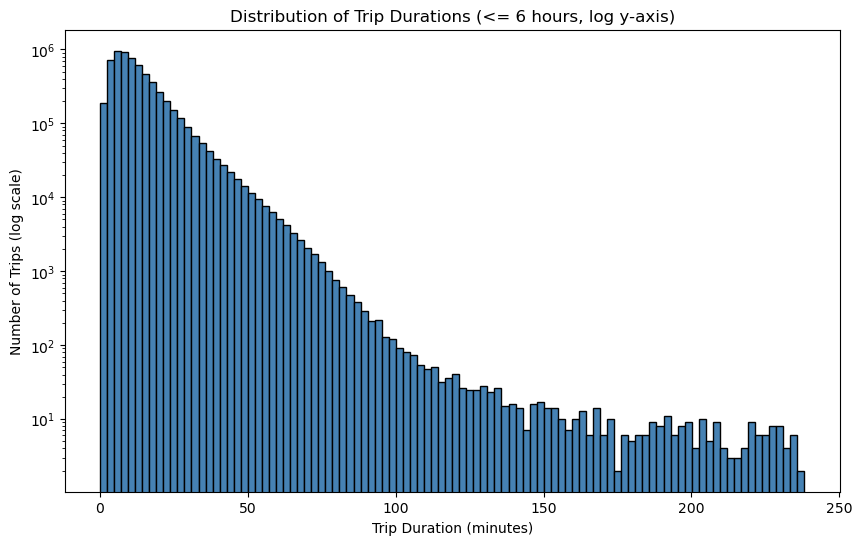

In [68]:
plt.figure(figsize=(10,6))
plt.hist(Taxi_Data[Taxi_Data['trip_duration'] <= 1300]['trip_duration'], 
         bins=100, color='steelblue', edgecolor='black')

plt.yscale('log')  # <-- log scale for y
plt.title("Distribution of Trip Durations (<= 6 hours, log y-axis)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Number of Trips (log scale)")
plt.show()

# One Hot Encoding

In [69]:
# Encoding all of the NYC boroughs
Taxi_Data = pd.get_dummies(
    Taxi_Data,
    columns=['PU_Borough', 'DO_Borough'],
    prefix=['PU', 'DO'],
    dtype=int
)

In [72]:
Taxi_Data = Taxi_Data[
    [
        'VendorID',
        'tpep_pickup_datetime', 'pickup_date', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek',
        'PULocationID',
        'PU_Bronx', 'PU_Brooklyn', 'PU_EWR', 'PU_Manhattan', 'PU_Queens', 'PU_Staten Island',
        'PU_Zone',
        'tpep_dropoff_datetime', 'dropoff_date', 'dropoff_hour', 'dropoff_minute', 'dropoff_dayofweek',
        'DOLocationID',
        'DO_Bronx', 'DO_Brooklyn', 'DO_EWR', 'DO_Manhattan', 'DO_Queens', 'DO_Staten Island',
        'DO_Zone',
        'trip_distance', 'trip_duration', 'passenger_count', 'RatecodeID',
        'store_and_fwd_flag', 'payment_type',
        'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
        'improvement_surcharge', 'total_amount', 'congestion_surcharge'
    ]
]
